In [1]:
import torch #pytorch
from torch.utils.data import Dataset #通常用於自定義數據加載與預處理
from torch.utils.data import DataLoader #批次傳送
from transformers import BertTokenizer #BERT分詞器
from transformers import BertForSequenceClassification #分類任務
from IPython.display import clear_output #用於清除輸出
from tqdm import tqdm #進度條
import pandas as pd #資料處理
from sklearn.model_selection import train_test_split #分割資料集
import time 

d:\Venv\Pytorch_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PRETRAINED_MODEL_NAME = "bert-base-chinese"  # 指定繁簡中文 BERT-BASE 預訓練模型

# 取得bert-base-chinese預訓練模型所使用的 tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
clear_output()

#查看該預訓練模型字典
vocab = tokenizer.vocab
print(f"字典大小： {len(vocab)}")

字典大小： 21128


In [3]:
df0 = pd.read_csv("./train_data/data_0.csv")
df1 = pd.read_csv("./train_data/data_1.csv")
df = pd.concat([df0, df1])

print(f"df  數量: {len(df)}")
print(f"df0 數量: {len(df0)}")
print(f"df1 數量: {len(df1)}")

df  數量: 3348
df0 數量: 1534
df1 數量: 1814


In [4]:
# 劃分數據集為訓練集、驗證集和測試集
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)  # 70% 訓練，30% 其他
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 15% 驗證，15% 測試

# 保存劃分後的數據集為新的 CSV 文件
train_df.to_csv("./train_data/train.csv", index=False, encoding='utf-8-sig')
val_df.to_csv("./train_data/val.csv", index=False, encoding='utf-8-sig')
test_df.to_csv("./train_data/test.csv", index=False, encoding='utf-8-sig')

In [5]:
class NewsSentimentDataset(Dataset):
    # 讀取前處理後的 csv 檔並初始化一些參數
    def __init__(self, mode, tokenizer, file_path):
        assert mode in ["train", "val", "test"]
        self.mode = mode
        self.df = pd.read_csv(file_path).fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer  # 使用 BERT tokenizer
        self.label_map = {0: 0, 1: 1}

    # 定義回傳"一筆"訓練 / 測試數據的函式
    def __getitem__(self, idx):
        content = self.df.iloc[idx]['內文_斷詞後']
        if self.mode == "test":
            label_tensor = None
        else:
            label = self.df.iloc[idx]['手動標註']
            # 將 label 文字也轉換成索引方便轉換成 tensor
            label_id = self.label_map[label]
            label_tensor = torch.tensor(label_id)

        tokens_tensor = self.tokenizer.encode(content,
                          add_special_tokens=True,  # like [CLS]
                          max_length=128,
                          truncation=True,
                          padding='max_length',
                          return_tensors='pt'
                          ).squeeze()  # 移除多餘的維度

        return tokens_tensor, label_tensor

    def __len__(self):
        return self.len

In [6]:
PRETRAINED_MODEL_NAME = "bert-base-chinese"
train_file_path = "./train_data/train.csv"

model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=2)
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
train_set = NewsSentimentDataset("train", tokenizer, train_file_path)
print(train_set.df.iloc[0]['內文_斷詞後'])
print(train_set[0])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


投資生存法則，就是要謹記四點（1）不買暴漲暴跌的股票（2）買龍頭股和股王（3）不買魚頭和魚尾，只買魚身（4）除息前一兩個禮拜買，除息前一天賣掉不買也可以用來參考！學無止境！不收任何費用，不合作，不下軟體次機會一定要抓住！祝願在股市中一路長紅
(tensor([ 101, 2832, 6536, 4495, 2100, 3791, 1179, 8024, 2218, 3221, 6206, 6346,
        6250, 1724, 7953, 8020,  122, 8021,  679, 6525, 3274, 4039, 3274, 6649,
        4638, 5500, 4873, 8020,  123, 8021, 6525, 7983, 7531, 5500, 1469, 5500,
        4374, 8020,  124, 8021,  679, 6525, 7797, 7531, 1469, 7797, 2227, 8024,
        1372, 6525, 7797, 6716, 8020,  125, 8021, 7370, 2622, 1184,  671, 1060,
         943, 4891, 2876, 6525, 8024, 7370, 2622, 1184,  671, 1921, 6546, 2957,
         679, 6525,  738, 1377,  809, 4500,  889, 1347, 5440, 8013, 2119, 4192,
        3632, 1862, 8013,  679, 3119,  818,  862, 6527, 4500, 8024,  679, 1394,
         868, 8024,  679,  678, 6727, 7768, 3613, 3582, 3298,  671, 2137, 6206,
        2831,  857, 8013, 4867, 7544, 1762, 5500, 2356,  704,  671, 6662, 7269,
        5148,  102,    0,    0,    0,    0,    0,    0]), tensor(1))


In [7]:
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples] # 內文token_tensor
    tokens_tensors = torch.stack(tokens_tensors) # 堆疊成二維形狀(len of list,max_length)
    # 若有標籤回傳label tensor
    if samples[0][1] is not None:
        label_ids = torch.stack([s[1] for s in samples])
    else:
        label_ids = None

    # attention masks，將 tokens_tensors 裡頭不為 zero padding
    # 的位置設為 1 讓 BERT 只關注這些位置的 tokens
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long) #dtype=int64
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)

    return tokens_tensors, masks_tensors, label_ids


In [8]:
BATCH_SIZE=32
trainloader=DataLoader(train_set, batch_size=BATCH_SIZE, collate_fn=create_mini_batch) #collate_fn接收單個數據樣本，並組成多樣本的批次
data = next(iter(trainloader))
print(f" token:{data[0].shape},\n mask:{data[1].shape},\n label:{data[2].shape}")
print(" ="*20)
print(f" token:{data[0]},\n mask:{data[1]},\n label:{data[2]}")

 token:torch.Size([32, 128]),
 mask:torch.Size([32, 128]),
 label:torch.Size([32])
 = = = = = = = = = = = = = = = = = = = =
 token:tensor([[ 101, 2832, 6536,  ...,    0,    0,    0],
        [ 101, 3418, 3315,  ...,    0,    0,    0],
        [ 101, 2802, 5050,  ...,    0,    0,    0],
        ...,
        [ 101, 4638, 2797,  ...,    0,    0,    0],
        [ 101, 6313, 4989,  ...,  671, 5143,  102],
        [ 101, 6313, 4989,  ...,  671, 5143,  102]]),
 mask:tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]),
 label:tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 1])


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 定義訓練函數
def train_model(trainloader, epochs, lr, batch_size, model):
    model.to(device)  # 將模型移動到 GPU 或 CPU
    model.train()  # 訓練模式
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # 設定優化器

    # 計時開始
    start_time = time.time()

    # 迭代訓練
    for epoch in range(epochs):
        running_loss = 0.0
        for data in trainloader:
            tokens_tensors, masks_tensors, labels = [t.to(device) for t in data]

            # 將參數梯度歸零
            optimizer.zero_grad()

            # forward pass
            outputs = model(input_ids=tokens_tensors, attention_mask=masks_tensors, labels=labels)

            loss = outputs[0]  # output 回傳 loss 與類別機率 (提取出來的是張量，取得其中元素使用 item())

            # backward
            loss.backward()
            optimizer.step()  # 更新參數

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader)}")

    # 計時結束
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training time: {elapsed_time:.2f} seconds")

    return model

In [10]:
# 載入一個可以做中文多分類任務的模型，n_class = 2
PRETRAINED_MODEL_NAME = "bert-base-chinese"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
NUM_LABELS = 2

batch_size = 32
epochs = 3
lr = 2e-5

def load_model():
  #下游任務：分類任務
  model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)
  clear_output()
  #將模型操作移轉到gpu上進行
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = model.to(device)

  return model



In [11]:
def pre_process(df, mode):
    file_path = f"{mode}.csv"
    df.to_csv(file_path, index=False)
    df_Dataset = NewsSentimentDataset(mode, tokenizer=tokenizer, file_path=file_path)
    df_DataLoader = DataLoader(df_Dataset, batch_size=batch_size, collate_fn=create_mini_batch)
    return df_Dataset, df_DataLoader

def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]

            tokens_tensors, masks_tensors = data[:2]
            outputs = model(input_ids=tokens_tensors, attention_mask=masks_tensors)
            logits = outputs[0]

            _, pred = torch.max(logits, 1)

            if compute_acc:
                labels = data[-1]
                total += labels.size(0)
                correct += (pred == labels).sum().item()

            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))

    if compute_acc:
        acc = correct / total
        return predictions, acc

    return predictions

In [12]:
acc_list = []
train_list = []
val_list = []

# 迴圈每次新增 train_df
for i in tqdm(range(10)):
    train_df = df.sample(frac=0.8, random_state=i)
    val_df = df.drop(train_df.index)

    train_df = train_df[['內文_斷詞後', '手動標註']]
    val_df = val_df[['內文_斷詞後', '手動標註']]

    train_list.append(f"第 {i+1} 次訓練")
    val_list.append(f"第 {i+1} 次驗證")

    trainset, trainloader = pre_process(train_df, mode='train')
    valset, valloader = pre_process(val_df, mode='val')

    model = load_model()

    fitted_model = train_model(trainloader, epochs, lr, batch_size, model)
    predictions, acc = get_predictions(fitted_model, valloader, compute_acc=True)
    print(acc)
    acc_list.append(acc)

result_df = pd.DataFrame({
    "train_period": train_list,
    "val_period": val_list,
    "acc": acc_list
})

avg_acc = sum(acc_list) / len(acc_list)
print(result_df)
print("平均準確度", avg_acc)

Epoch 1/3, Loss: 0.1772241817698592
Epoch 2/3, Loss: 0.04503448631814016
Epoch 3/3, Loss: 0.020124710300089128
Training time: 268.65 seconds


100%|██████████| 10/10 [44:47<00:00, 268.72s/it]

0.9841269841269841
  train_period val_period       acc
0      第 1 次訓練    第 1 次驗證  0.994413
1      第 2 次訓練    第 2 次驗證  0.988095
2      第 3 次訓練    第 3 次驗證  0.980296
3      第 4 次訓練    第 4 次驗證  0.977778
4      第 5 次訓練    第 5 次驗證  0.981013
5      第 6 次訓練    第 6 次驗證  0.988439
6      第 7 次訓練    第 7 次驗證  0.980000
7      第 8 次訓練    第 8 次驗證  0.982036
8      第 9 次訓練    第 9 次驗證  0.976471
9     第 10 次訓練   第 10 次驗證  0.984127
平均準確度 0.9832667455288929


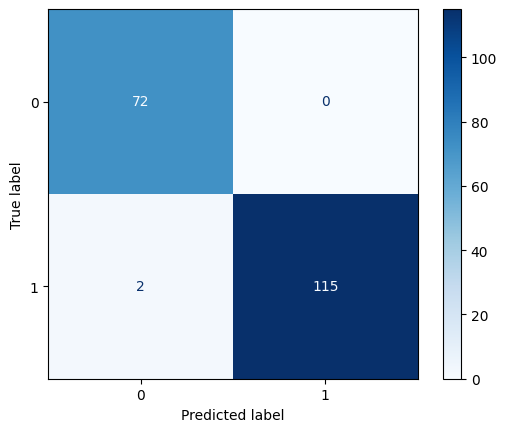

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


predictions, labels = [], []
model.eval() # 模型評估模式

# 使用驗證集進行預測
with torch.no_grad():
    for data in valloader:
        tokens_tensors, masks_tensors, label_ids = [t.to(device) for t in data]
        
        # forward pass
        outputs = model(input_ids=tokens_tensors,
                        attention_mask=masks_tensors)
        
        logits = outputs.logits
        _, preds = torch.max(logits, 1)
        
        predictions.extend(preds.cpu().numpy())
        labels.extend(label_ids.cpu().numpy())

cm = confusion_matrix(labels, predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap=plt.cm.Blues)


In [14]:
import os

output_dir = './Model_Save/'

if not os.path.exists(output_dir): # 如果目錄不存在，則建立該目錄
    os.makedirs(output_dir)

# 儲存模型
model_save_path = os.path.join(output_dir, 'bert_classification_model.bin')
torch.save(model.state_dict(), model_save_path)

# 儲存 tokenizer
tokenizer_save_path = os.path.join(output_dir, 'bert_tokenizer/')
tokenizer.save_pretrained(tokenizer_save_path)

print(f"模型已儲存到 {model_save_path}")
print(f"Tokenizer 已儲存到 {tokenizer_save_path}")

模型已儲存到 ./Model_Save/bert_classification_model.bin
Tokenizer 已儲存到 ./Model_Save/bert_tokenizer/
